## Imports

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
# Optional: for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
import os

import warnings


In [11]:
# Replace 'output_properties-v1.csv' with the actual path to your file
try:
  output_props = pd.read_csv('output_properties-v2.csv')
  print(output_props.head())  # Print the first few rows to verify it loaded correctly
  print(output_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")

try:
  input_e_props = pd.read_csv('input_properties-e-v2.csv')
  print(input_e_props.head())  # Print the first few rows to verify it loaded correctly
  print(input_e_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")

try:
  input_f_props = pd.read_csv('input_properties-f-v2.csv')
  print(input_f_props.head())  # Print the first few rows to verify it loaded correctly
  print(input_f_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")


     vf  ematerial  fmaterial           c44       e15         q15       μ11  \
0  0.05          1          1  4.766571e+10  0.015891  496.356224  0.000142   
1  0.10          1          1  4.828090e+10  0.027298  449.900677  0.000129   
2  0.15          1          1  4.893927e+10  0.039258  409.485667  0.000118   
3  0.20          1          1  4.962150e+10  0.052453  372.497082  0.000108   
4  0.25          1          1  5.031985e+10  0.067351  338.035646  0.000098   

            ϵ11           α11       ρ  
0  9.727373e-11 -4.046668e-12  5320.0  
1  1.077914e-10 -6.693664e-12  5340.0  
2  1.188914e-10 -9.065879e-12  5360.0  
3  1.311074e-10 -1.127972e-11  5380.0  
4  1.448213e-10 -1.337401e-11  5400.0  
(1045, 10)
   material_code          c55f  e15f  q15f          ϵ11f      μ11f  α11f    ρf
0              1  4.400000e+10  11.4   0.0  9.820000e-09  0.000005     0  5700
1              2  2.560000e+10  12.7   0.0  6.460000e-09  0.000005     0  7500
2              3  2.500000e+10  13.5 

## Data Preprations

### Data PreProcessing

In [12]:
# prompt: Make a new dataframe.
# and iterate through all the elements in output_props and find assign the properties given in the input_f_props and input_e_props such such that if the ematerial==material_code in input_e_props then replace ematerial with all the 6 properties given in the input_e_props. same goes wiht the input_f_props and fmateria

temp_dataset = output_props.copy()

for index, row in temp_dataset.iterrows():
  e_material = row['ematerial']
  f_material = row['fmaterial']

  # Find matching rows in input_e_props and input_f_props
  matching_e_props = input_e_props[input_e_props['material_code'] == e_material]
  matching_f_props = input_f_props[input_f_props['material_code'] == f_material]

  if not matching_e_props.empty:
    # Replace ematerial properties with values from input_e_props
    for col in ['c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf']:
      temp_dataset.loc[index, col] = matching_e_props[col].iloc[0]

  if not matching_f_props.empty:
    # Replace fmaterial properties with values from input_f_props
    # for col in ['f_density', 'f_youngs_modulus', 'f_poissons_ratio', 'f_thermal_conductivity', 'f_specific_heat', 'f_thermal_expansion']:
    # for col in ['c55m', 'e15m', 'q15m', 'ϵ11m', 'μ11m', 'α11m', 'ρm']:
    for col in ['c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf']:
      col_name = col[:-1]+'m'
      temp_dataset.loc[index, col_name] = matching_f_props[col].iloc[0]

temp_dataset.drop(columns=['ematerial', 'fmaterial'], inplace=True)

print("temp_dataset shape",temp_dataset.shape)
print("temp_dataset columns", temp_dataset.columns.tolist())

#22 columns 1 vf 7*2 props and 7 output props


# prompt: cut the last 12 coloumns in the dataset and paste them after the first column

last_12_cols = temp_dataset.iloc[:, -14:]
first_cols = temp_dataset.iloc[:,0]
remaining_cols = temp_dataset.iloc[:, 1:-14]
dataset = pd.concat([first_cols, last_12_cols, remaining_cols], axis=1)
print("Dataset\n",dataset.head())
print("Dataset columns",dataset.columns.tolist())

temp_dataset shape (1045, 22)
temp_dataset columns ['vf', 'c44', 'e15', 'q15', 'μ11', 'ϵ11', 'α11', 'ρ', 'c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf', 'c55m', 'e15m', 'q15m', 'ϵ11m', 'μ11m', 'α11m', 'ρm']
Dataset
      vf          c55f  e15f  q15f          ϵ11f      μ11f  α11f      ρf  \
0  0.05  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
1  0.10  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
2  0.15  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
3  0.20  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
4  0.25  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   

           c55m  e15m   q15m          ϵ11m      μ11m  α11m      ρm  \
0  4.530000e+10   0.0  550.0  8.000000e-11  0.000157   0.0  5300.0   
1  4.530000e+10   0.0  550.0  8.000000e-11  0.000157   0.0  5300.0   
2  4.530000e+10   0.0  550.0  8.000000e-11  0.000157   0.0  5300.0   
3  4.530000e+10   0.0  550.0  8.000000e-11  0.0

In [13]:
pd.set_option('display.max_columns', None)
dataset.describe()

,vf,c55f,e15f,q15f,ϵ11f,μ11f,α11f,ρf,c55m,e15m,q15m,ϵ11m,μ11m,α11m,ρm,c44,e15,q15,μ11,ϵ11,α11,ρ
count,1045.000000,1.045000e+03,1045.000000,1045.0,1.045000e+03,1045.000000,1045.0,1045.000000,1.045000e+03,1045.0,1045.000000,1.045000e+03,1045.000000,1.045000e+03,1045.000000,1.045000e+03,1045.000000,1045.000000,1045.000000,1.045000e+03,1.045000e+03,1045.000000
mean,0.500000,3.410000e+10,11.210909,0.0,7.230164e-07,0.000002,0.0,6025.454545,1.128180e+11,0.0,143.532001,3.008000e-02,0.002184,8.000000e-10,6026.000000,7.294168e+10,3.875238,39.143811,0.000811,-1.385889e-02,-4.344651e-09,6025.727273
std,0.273992,1.689466e+10,5.118779,0.0,9.039253e-07,0.000002,0.0,1974.664943,1.630179e+11,0.0,213.457588,6.018881e-02,0.002146,7.486898e-10,1608.222312,2.781473e+11,91.778803,426.254127,0.001103,3.601466e-01,2.567599e-08,1451.842357
min,0.050000,9.000000e+08,0.000000,0.0,6.460000e-09,0.000001,0.0,1780.000000,5.990000e+09,0.0,0.000001,8.000000e-11,0.000004,0.000000e+00,5000.000000,-5.821872e+12,-1774.676893,-6137.643563,-0.000316,-5.491630e+00,-2.622378e-07,1941.000000
25%,0.250000,2.280000e+10,8.400000,0.0,9.820000e-09,0.000001,0.0,4500.000000,3.230000e+10,0.0,0.000002,1.000000e-10,0.000157,0.000000e+00,5200.000000,3.265951e+10,0.001469,0.000005,0.000033,2.031856e-10,-1.627997e-13,5040.000000
50%,0.500000,3.270000e+10,11.400000,0.0,2.580000e-07,0.000001,0.0,5700.000000,4.300000e+10,0.0,0.000002,1.100000e-10,0.001260,1.000000e-09,5300.000000,4.366674e+10,0.013506,0.000838,0.000264,4.068971e-10,1.430167e-10,5660.000000
75%,0.750000,4.740000e+10,13.500000,0.0,9.380000e-07,0.000005,0.0,7800.000000,4.530000e+10,0.0,167.660000,1.330000e-10,0.004500,1.000000e-09,5400.000000,6.082821e+10,0.483156,145.529910,0.001123,1.641847e-09,5.002469e-10,7080.000000
max,0.950000,6.300000e+10,21.120000,0.0,2.779000e-06,0.000005,0.0,8200.000000,4.375000e+11,0.0,550.000000,1.504000e-01,0.005000,2.000000e-09,9230.000000,3.426418e+12,1245.566220,1076.358783,0.004292,5.621080e-01,3.141651e-07,9178.500000


### Exploratory Data Analysis


### Feature Scalling

In [15]:
# Initialize scalers and PCA
input_standard_scaler = StandardScaler()
poly_standard_scaler = StandardScaler()
input_minmax_scaler = MinMaxScaler()
output_scaler = StandardScaler()
pca = PCA(n_components=15)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)


def transform_input(input_df, is_new = False):
    # Standardize selected features
    standardized_features = input_standard_scaler.fit_transform(input_df)
    
    return standardized_features


# 2. Function to transform the output dataset
def transform_output(output_df, is_new = False):
    # Standardize output features
    if is_new:  
        scaled_output = output_scaler.transform(output_df)
    else:
        scaled_output = output_scaler.fit_transform(output_df)
    return scaled_output

# 3. Function to inverse transform the output predictions back to original scale
def inverse_transform_output(scaled_output):
    original_output = output_scaler.inverse_transform(scaled_output)
    return original_output


In [16]:
# Example usage with your dataset
input_df = dataset.iloc[:, :15]  # First 15 columns as input features
output_df = dataset.iloc[:, 15:]  # Last 7 columns as output features

# Transform datasets
processed_inputs = transform_input(input_df)
processed_outputs = transform_output(output_df)

X = processed_inputs
y = processed_outputs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("input_df" ,input_df.shape, type(X))
print("output_df", output_df.shape, type(y))

print("X.shape" ,X.shape, type(X))
print("y.shape", y.shape, type(y))

print("X_train.shape" ,X_train.shape, type(X_train))
print("y_train.shape", y_train.shape, type(y_train))
print("X_test.shape", X_test.shape)
print("y_test.shape",y_test.shape)

input_df (1045, 15) <class 'numpy.ndarray'>
output_df (1045, 7) <class 'numpy.ndarray'>
X.shape (1045, 15) <class 'numpy.ndarray'>
y.shape (1045, 7) <class 'numpy.ndarray'>
X_train.shape (836, 15) <class 'numpy.ndarray'>
y_train.shape (836, 7) <class 'numpy.ndarray'>
X_test.shape (209, 15)
y_test.shape (209, 7)


## Model Prepration

### Neural Network

In [26]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

# def r2_score(y_true, y_pred):
#     return r2_score(y_test, y_pred)


def build_model(input_shape):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(input_shape,)))
    # model.add(layers.Dense(128, activation='purelin', kernel_initializer='he_normal'))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='tanh', kernel_initializer='he_normal'))
    # model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='tanh', kernel_initializer='he_normal'))
    model.add(layers.Dense(7))
    # layers.Dense.activation.

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r2_score])
    
    return model




# Build and compile the model
model = build_model(X_train.shape[1])
# model = build_adv_model(X_train.shape[1])

# Model summary
model.summary()


/Users/vivek/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,335 (13.03 KB)

 Trainable params: 3,335 (13.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,  
    batch_size=4,
    callbacks=[early_stopping]
)


'''
with batch_size = 16
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.4251 - mae: 0.2641 - r2_score: 0.6404 - val_loss: 0.2725 - val_mae: 0.1966 - val_r2_score: 0.7683
with batch_size = 8
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.6690 - mae: 0.2397 - r2_score: 0.7009 - val_loss: 0.1744 - val_mae: 0.1508 - val_r2_score: 0.8667
with batch size = 5
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.6705 - mae: 0.2310 - r2_score: 0.7329 - val_loss: 0.1759 - val_mae: 0.1284 - val_r2_score: 0.9056
with batch size = 4
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.5257 - mae: 0.2026 - r2_score: 0.7594 - val_loss: 0.1747 - val_mae: 0.1271 - val_r2_score: 0.9120
with batch size = 2
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.7710 - mae: 0.1880 - r2_score: 0.8285 - val_loss: 0.1085 - val_mae: 0.1029 - val_r2_score: 0.9368
with batch size = 1
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.3884 - mae: 0.1410 - r2_score: 0.8242 - val_loss: 0.1261 - val_mae: 0.1010 - val_r2_score: 0.9287

'''

Epoch 1/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 1.7489 - mae: 0.8762 - r2_score: -2.9224 - val_loss: 1.0856 - val_mae: 0.6964 - val_r2_score: -1.3427
Epoch 2/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 1.2391 - mae: 0.6273 - r2_score: -0.8374 - val_loss: 0.7625 - val_mae: 0.5175 - val_r2_score: -0.3044
Epoch 3/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 1.0319 - mae: 0.4957 - r2_score: -0.2119 - val_loss: 0.6388 - val_mae: 0.4246 - val_r2_score: 0.1108
Epoch 4/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1.1483 - mae: 0.4269 - r2_score: 0.1402 - val_loss: 0.5776 - val_mae: 0.3707 - val_r2_score: 0.3071
Epoch 5/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.6897 - mae: 0.3596 - r2_score: 0.3172 - val_loss: 0.5440 - val_mae: 0.3408 - val_r2_score: 0.4100
Epoch 6/1000
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.6588 - mae: 0.3493 - r2_score: 0.4214 - val_loss: 0.5222 - val_mae: 0.3213 - val_r2_score: 0.4766
Epoch 7/100

'\nwith batch_size = 16\n42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 0.4251 - mae: 0.2641 - r2_score: 0.6404 - val_loss: 0.2725 - val_mae: 0.1966 - val_r2_score: 0.7683\nwith batch_size = 8\n84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.6690 - mae: 0.2397 - r2_score: 0.7009 - val_loss: 0.1744 - val_mae: 0.1508 - val_r2_score: 0.8667\nwith batch size = 5\n134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.6705 - mae: 0.2310 - r2_score: 0.7329 - val_loss: 0.1759 - val_mae: 0.1284 - val_r2_score: 0.9056\nwith batch size = 4\n167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.5257 - mae: 0.2026 - r2_score: 0.7594 - val_loss: 0.1747 - val_mae: 0.1271 - val_r2_score: 0.9120\nwith batch size = 2\n334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.7710 - mae: 0.1880 - r2_score: 0.8285 - val_loss: 0.1085 - val_mae: 0.1029 - val_r2_score: 0.9368\nwith batch size = 1\n668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.3884 - mae: 0.1410 - r2_score: 0.8242 - val_loss: 0.1261 - va

### Evaluate Model

In [28]:
# if os.path.exists(file_path):
#     model.load_weights(file_path)

# Evaluate on the test set
test_loss, test_mae, r2_square = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test r2 score: {r2_square}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.1803 - mae: 0.0954 - r2_score: 0.8441
Test Loss: 0.41699808835983276, Test MAE: 0.12475428730249405, Test r2 score: 0.7252865433692932


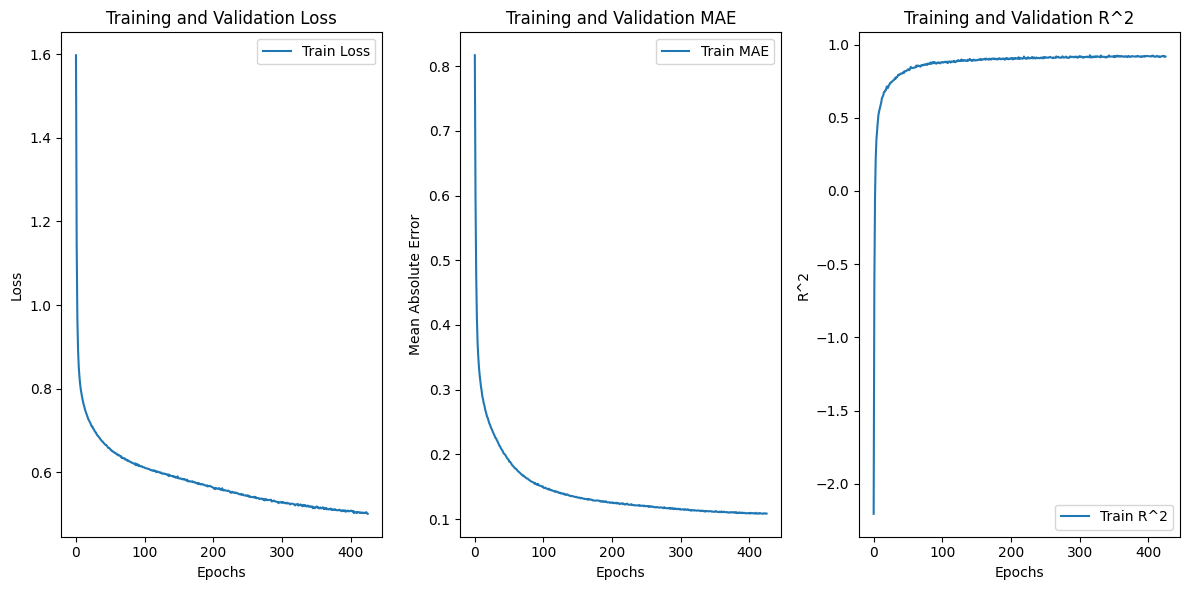

In [29]:
'''
3. Model Training Loss and Metrics Over Epochs
We'll visualize the training and validation loss/MAE over epochs to see if the model is converging and whether there are any signs of overfitting.

            ##SIMPLE MODEL
            
'''

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# R Square
plt.subplot(1, 3, 3)
plt.plot(history.history['r2_score'], label='Train R^2')
# plt.plot(history.history['val_r2_score'], label='Validation R^2')
plt.title('Training and Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2')
plt.legend()


plt.tight_layout()
plt.show()


## Custom Testing

In [30]:
input_column_names = ["vf",	"c55f",	"e15f",	"q15f",	"ϵ11f",	"μ11f",	"α11f",	"ρf",	"c55m",	"e15m",	"q15m",	"ϵ11m",	"μ11m",	"α11m",	"ρm"]
output_column_names = ["c55","e15","q15","μ11","ϵ11","α11","ρ"]

custom_pe = [0.1, 4.74e10,5.9,0,0.000000258,1.256e-6,0,5700]
custom_pm = [4.375e11,0,1.8e-6,1.1000000000000001e-10,0.005,0,5000]
custom_X = custom_pe + custom_pm

custom_y = [3.634176310743966e11,0.0011903620665069834,6.955282500718291e-6,0.0038911902497417283,1.4342425019093703e-10,1.55647598734026e-9,5070]

custom_X_df = pd.DataFrame([custom_X], columns=input_column_names)
custom_y_df = pd.DataFrame([custom_y], columns=output_column_names)

In [ ]:
def predict_and_compare(custom_X_df, original_y_df, print_results=True):
    
    custom_X_scaled = transform_input(custom_X_df, is_new=True)
    custom_y_pred_scaled = model.predict(custom_X_scaled)
    custom_y_pred = inverse_transform_output2(custom_y_pred_scaled, original_y_df.iloc[i])

    if print_results:
        for i in range(0, custom_y_pred.shape[0]):
            print("input properties ", "i : {", *custom_X_df.iloc[i].values, "}", end="\n")
            print(compare_vectors(custom_y_pred[i], original_y_df.iloc[i]), end="\n\n")

    return custom_y_pred

def compare_vectors(vector1, vector2):
    
    # Create a DataFrame for tabular comparison
    df = pd.DataFrame({
        'Predicted Output': vector1,
        'Real Output': vector2,
        'Difference': [v1 - v2 if v1 is not None and v2 is not None else None for v1, v2 in zip(vector1, vector2)]
    }, index=output_column_names)
    
    return df

In [32]:
result = predict_and_compare(custom_X_df, custom_y_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
input properties  i : { 0.1 47400000000.0 5.9 0.0 2.58e-07 1.256e-06 0.0 5700.0 437500000000.0 0.0 1.8e-06 1.1000000000000001e-10 0.005 0.0 5000.0 }
     Predicted Output   Real Output    Difference
c55     -8.628838e+10  3.634176e+11 -4.497060e+11
e15     -1.506450e+01  1.190362e-03 -1.506569e+01
q15     -4.378633e+02  6.955283e-06 -4.378633e+02
μ11      1.788766e-04  3.891190e-03 -3.712314e-03
ϵ11     -3.789091e-01  1.434243e-10 -3.789091e-01
α11      3.098712e-09  1.556476e-09  1.542236e-09
ρ        7.543848e+03  5.070000e+03  2.473848e+03



## Graphical Representations


In [97]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


In [98]:
y_pred_denormalized = inverse_transform_output(y_pred)
y_test_denormalized = inverse_transform_output(y_test)

# Calculate R^2 score for each output property
r2_scores = [r2_score(y_test_denormalized[:, i], y_pred_denormalized[:, i]) for i in range(y_test_denormalized.shape[1])]
print("R^2 Scores for each output property:")
for i, r2 in enumerate(r2_scores):
    print(f"{output_column_names[i]}: {r2}")

# Calculate mean R^2 score
mean_r2 = np.mean(r2_scores)
print(f"Mean R^2 Score: {mean_r2}")


'''
R^2 Scores for each output property:
c44: -0.023763608963201843
e15: 0.007695597598103676
q15: 0.8165017201958011
μ11: 0.9907636647500426
ϵ11: 0.820310869031279
α11: 0.9999993924113815
ρ: 0.9826377835129602
Mean R^2 Score: 0.656306488362338
'''

R^2 Scores for each output property:
c55: 0.02998054953803475
e15: 0.03707895699445274
q15: 0.7301504615992791
μ11: 0.9891436215921261
ϵ11: 0.7120222541809695
α11: 0.9999994149373346
ρ: 0.9781682885861468
Mean R^2 Score: 0.639506221061192


'\nR^2 Scores for each output property:\nc44: -0.023763608963201843\ne15: 0.007695597598103676\nq15: 0.8165017201958011\nμ11: 0.9907636647500426\nϵ11: 0.820310869031279\nα11: 0.9999993924113815\nρ: 0.9826377835129602\nMean R^2 Score: 0.656306488362338\n'

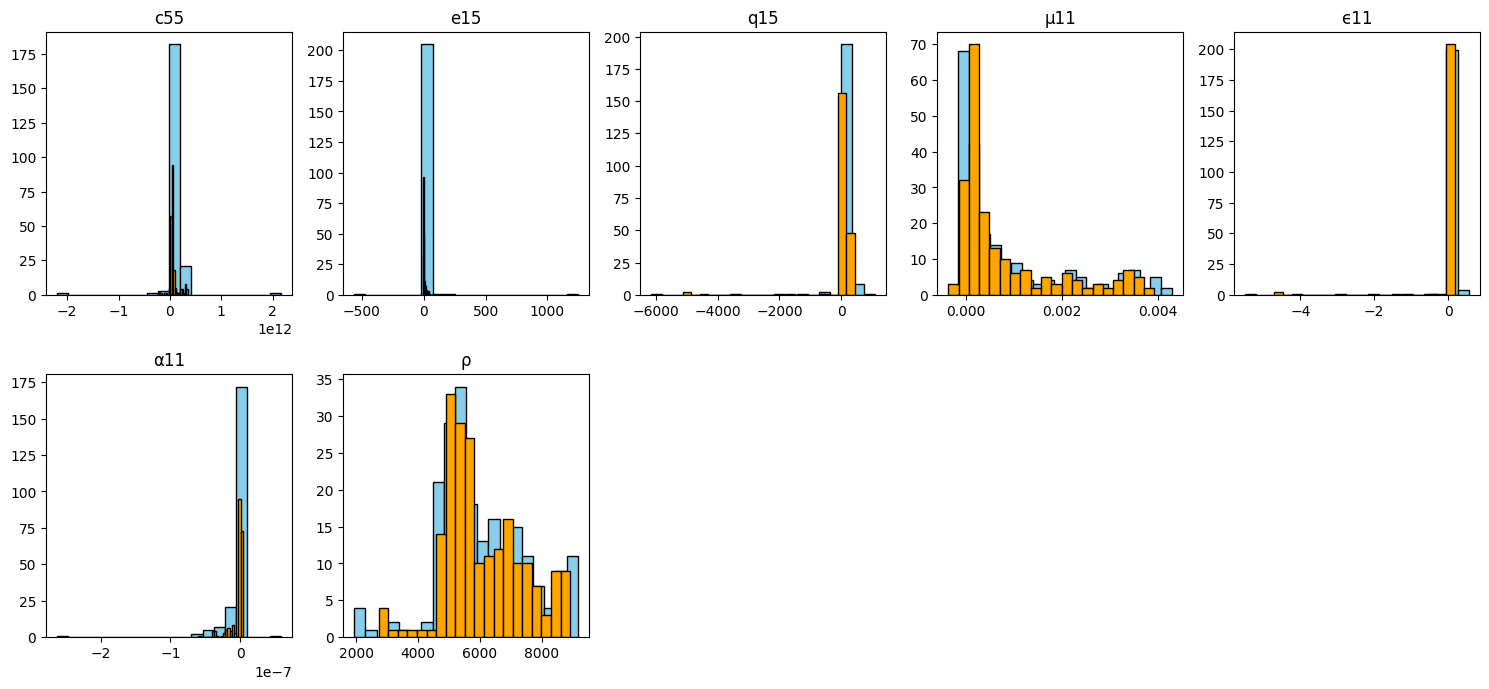

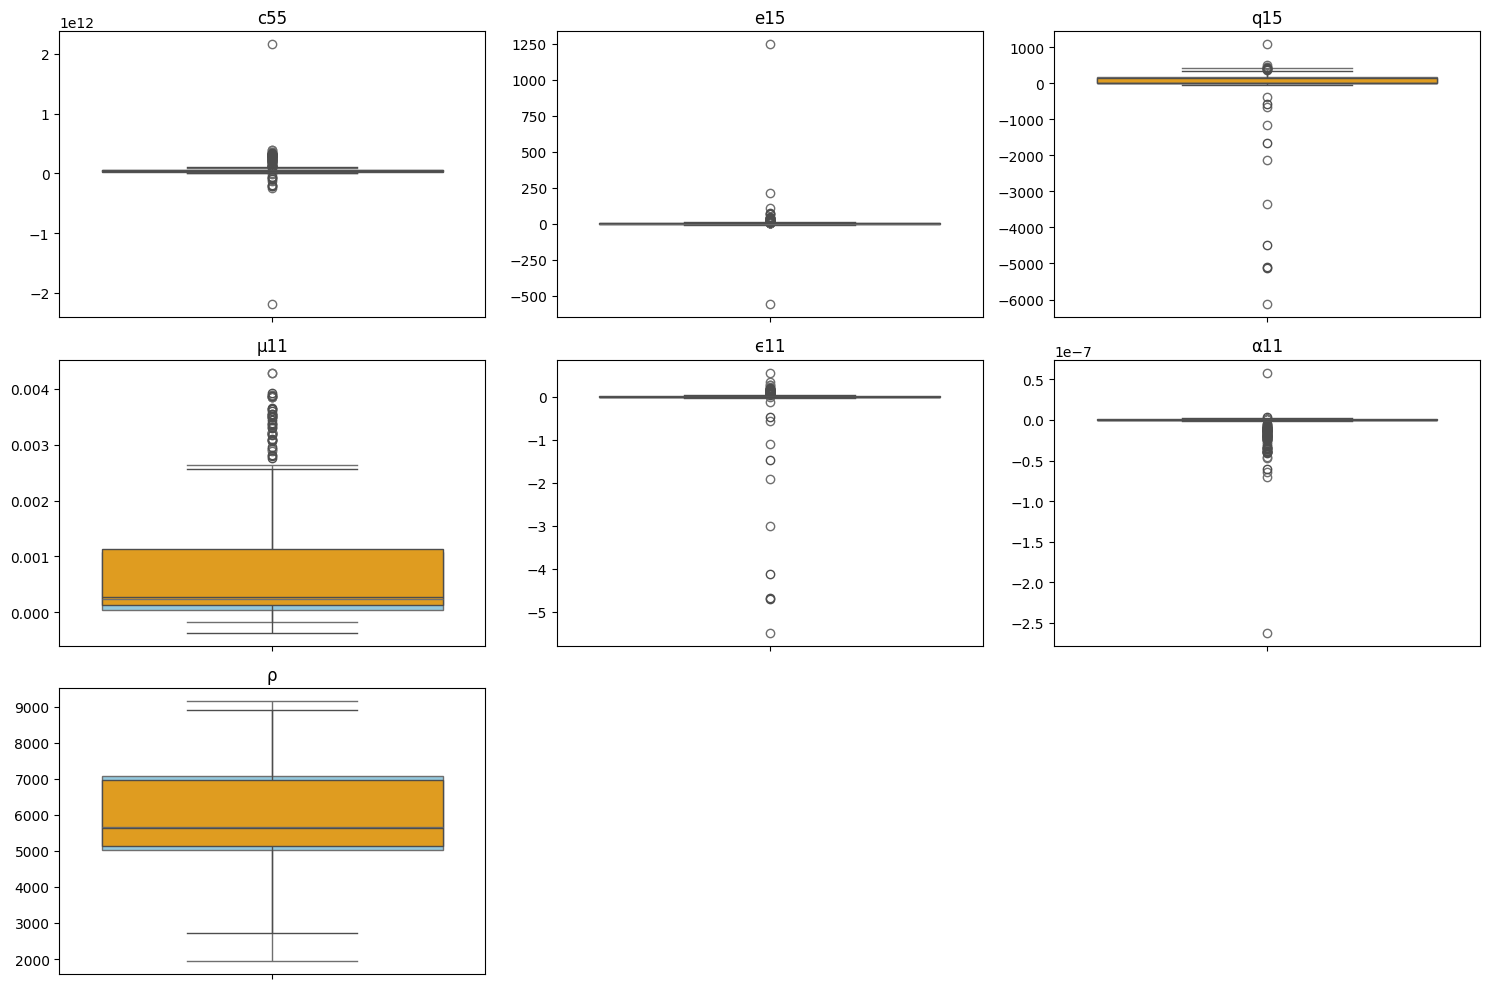

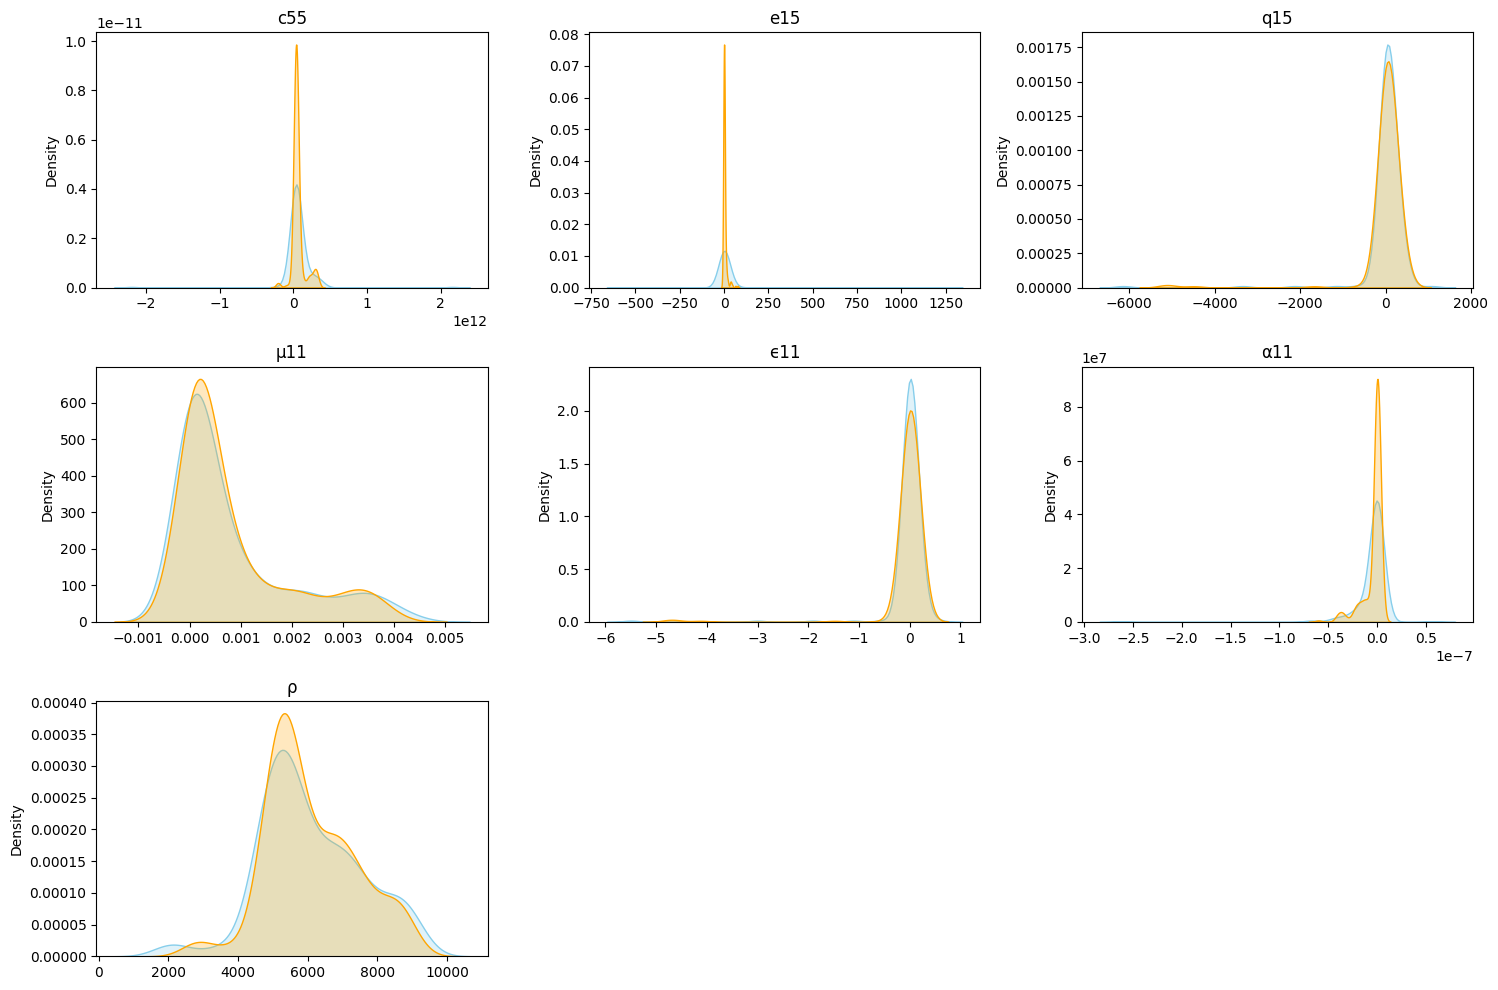

In [99]:
#We'll plot histograms to visualize the distribution of the input features (material properties and volume fraction).

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(15, 10))
    for i in range(7):
        plt.subplot(3, 5, i+1)
        plt.hist(y_test_denormalized[:, i], bins=20, color='skyblue', edgecolor='black', )
        plt.hist(y_pred_denormalized[:, i], bins=20, color='orange', edgecolor='black')
        plt.title(output_column_names[i])
    plt.tight_layout()
    plt.show()
    # We'll plot boxplots to visualize the distribution of the input features (material properties and volume fraction).

    plt.figure(figsize=(15, 10))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        sns.boxplot(y=y_test_denormalized[:, i], color='skyblue')
        sns.boxplot(y=y_pred_denormalized[:, i], color='orange')
        plt.title(output_column_names[i])
    plt.tight_layout()
    plt.show()
    # We'll plot KDE (Kernel Density Estimate) plots to visualize the distribution of the input features (material properties and volume fraction).

    plt.figure(figsize=(15, 10))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        sns.kdeplot(y_test_denormalized[:, i], shade=True, color='skyblue')
        sns.kdeplot(y_pred_denormalized[:, i], shade=True, color='orange')
        plt.title(output_column_names[i])
    plt.tight_layout()
    plt.show()

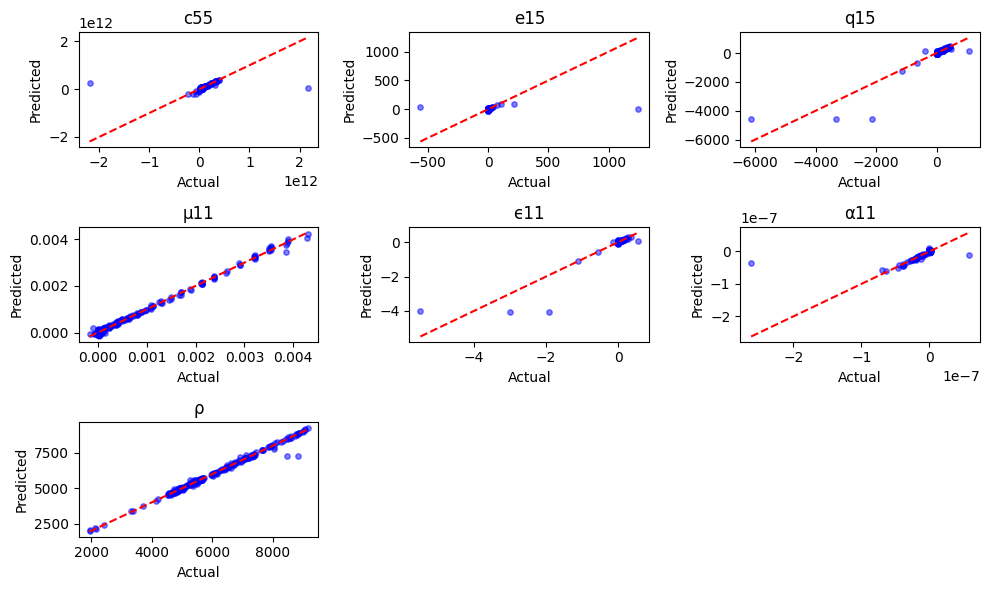

In [46]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
for i in range(7):
    plt.subplot(3, 3, i+1)
    plt.scatter(y_test_denormalized[:, i], y_pred_denormalized[:, i], color='blue', alpha=0.5, s=15)
    plt.plot([min(y_test_denormalized[:, i]), max(y_test_denormalized[:, i])],
             [min(y_test_denormalized[:, i]), max(y_test_denormalized[:, i])], 'r--')
    plt.title(output_column_names[i])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


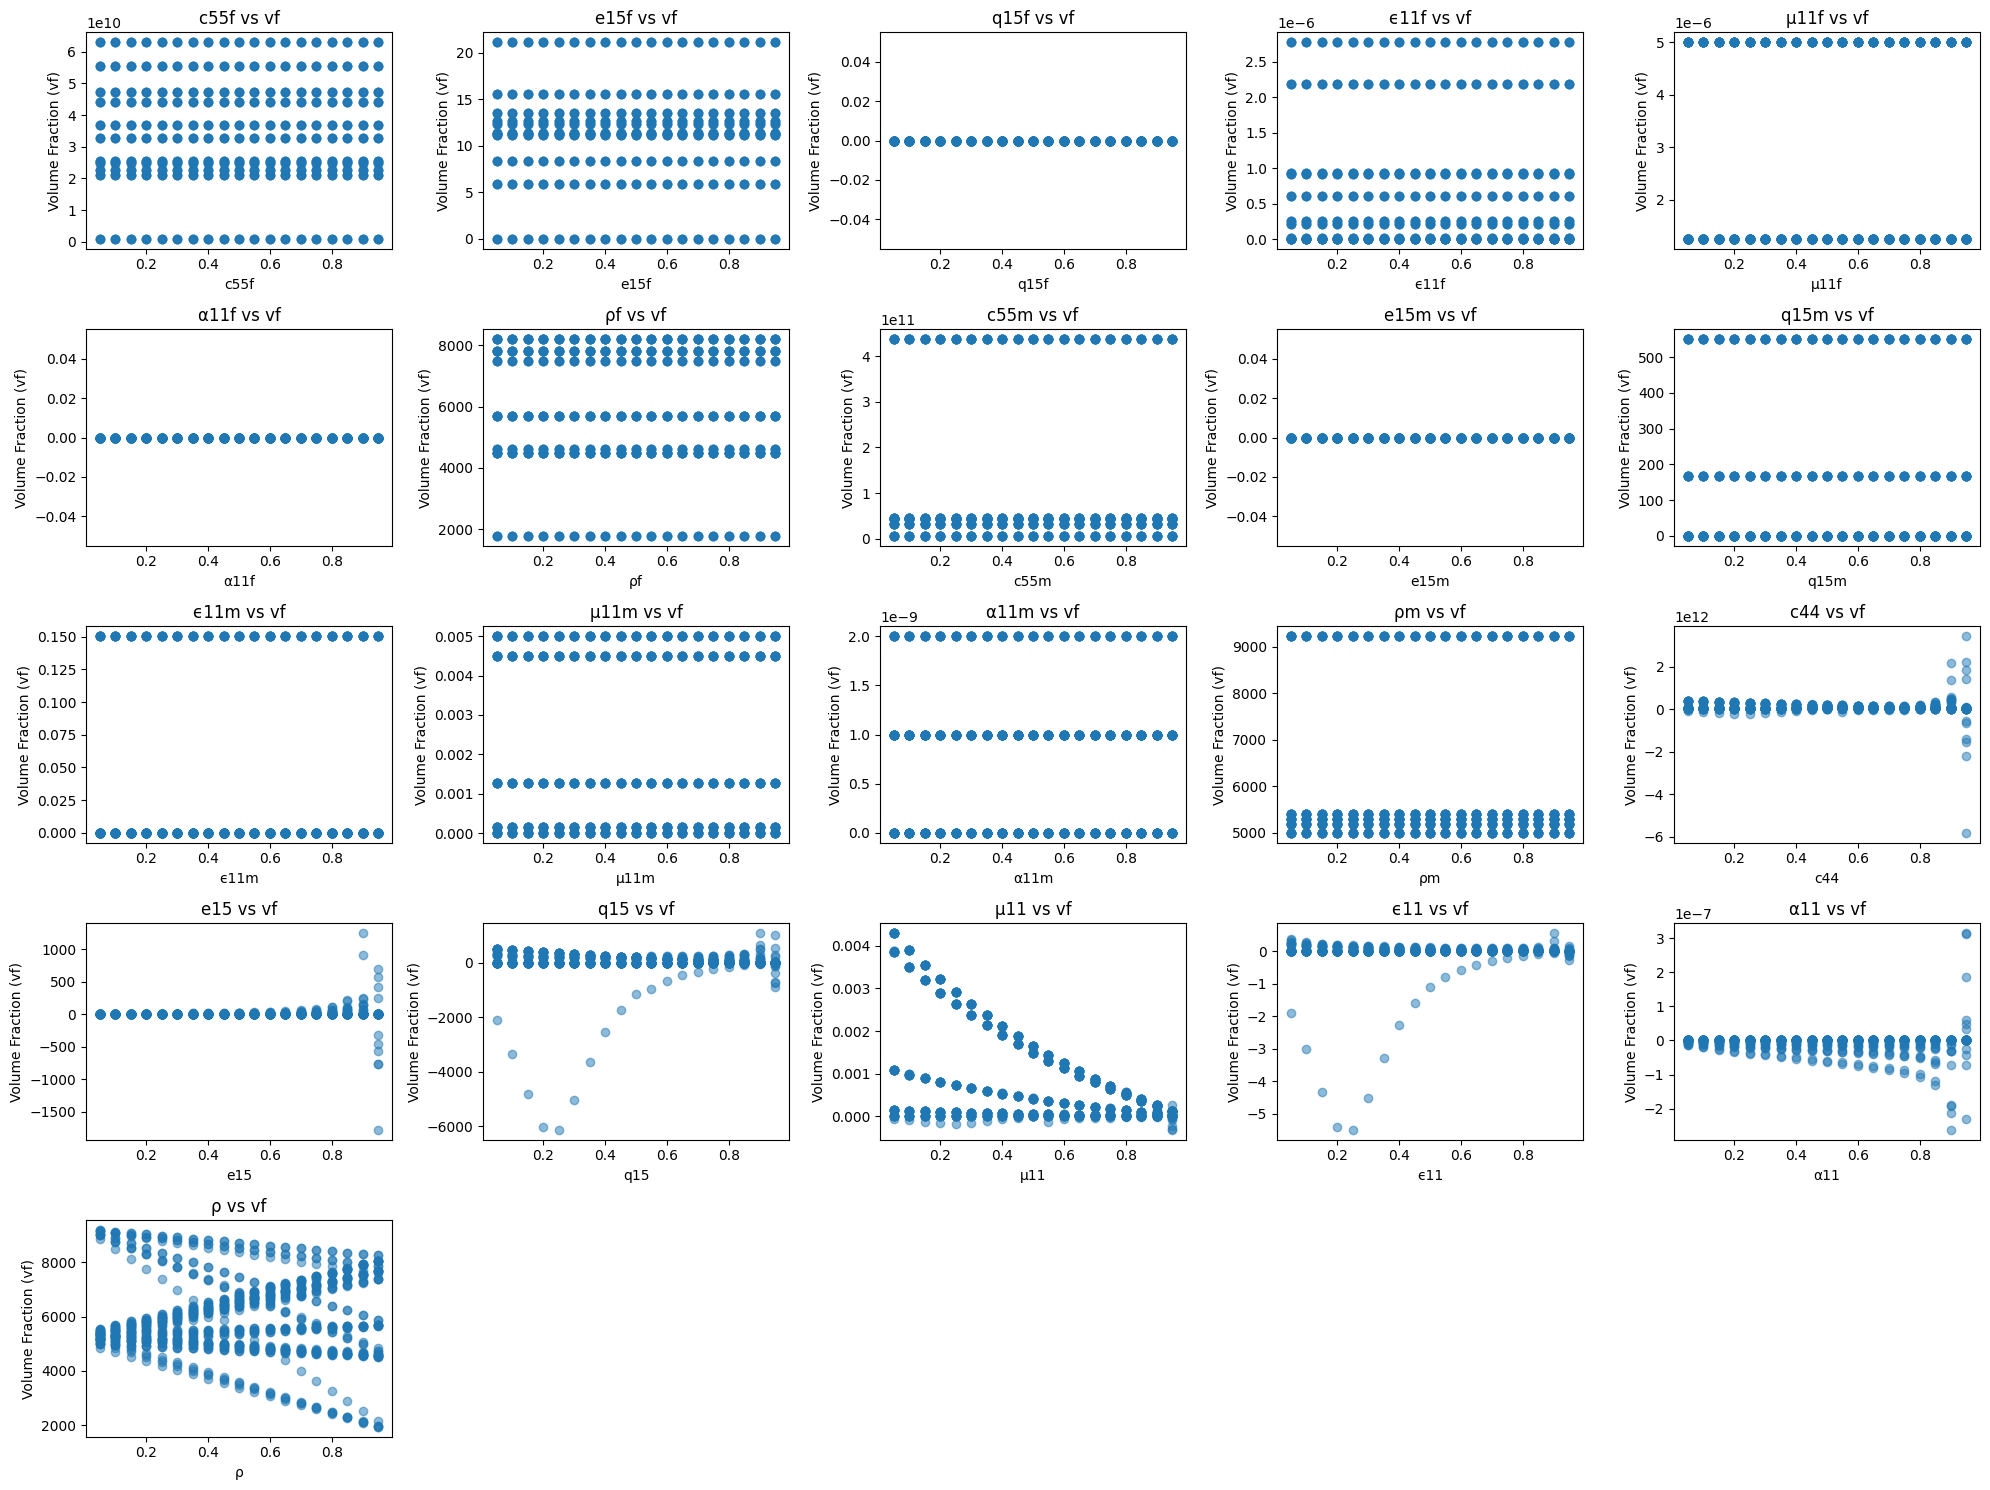

In [47]:
# Plot how all the features are changing based on the volume fraction
plt.figure(figsize=(20, 15))

# List of all feature columns
feature_columns = dataset.columns[1:]  # Exclude 'vf' column

# Create scatter plots for each feature against 'vf'
for i, feature in enumerate(feature_columns):
    plt.subplot(5, 5, i + 1)
    plt.scatter(dataset['vf'], dataset[feature], alpha=0.5)
    plt.title(f'{feature} vs vf')
    plt.ylabel('Volume Fraction (vf)')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()